### 1. Общая информация

Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов: int – полноэкранная реклама; banner – горизонтальный баннер, висит внизу экрана пока юзер играет; rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.

eCPM – доход за 1000 показов рекламы.

### 2. Бизнес задача

Провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. 

### 3. Что требуется

1. Для каждого формата рекламы:
* построить распределение средних eCPM-ов юзеров
* построить распределение eCPM-ов по городам, версиям ОС
* построить распределение доходов по городам, версиям ОС
2. Учесть статистическую значимость (отобразить, отфильтровать незначимое или хотя бы прокомментировать). Объяснить решение.
3. Описать наблюдения и вывод по исследованию.


### 4. Дополнительные (по желанию)

Исследовать:

* Какой процент доходов содержит информацию о городе юзера 
* Зависит ли eCPM от времени дня

### 5. Вспомогательная информация
Столбец profile_id – id юзера

Столбец event_json содержит данные о событии показа рекламы:
* ad_type – формат рекламы (int, banner или rv)
* placement – когда/где был показ рекламы в игре
* view_index – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
* revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000) 
* ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера
* network_name – рекламная сеть, от которой был показ

Остальные столбцы должны быть интуитивно понятны

### 6. После выполнения

По готовности, опубликуйте Jupyter Notebook с выполненным заданием на github и пришлите ссылку на репозиторий.

При оценке выполненного задания будет оцениваться:
* на сколько понятно визуализированы данные, хорошо ли выбраны средства для презентации данных (типы диаграмм, таблиц или др.)
* чистота и понятность кода
* описания наблюдений в процессе иследования и сделанные выводы


---
Импортирую необходимые библиотеки

In [312]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

Загружаем данные

In [2]:
df = pd.read_csv('us events ad_revenue filtered 03.02-07.02.csv')

In [5]:
df.shape

(860079, 16)

Первым шагом необходимо преобразовать json данные в колонки и присоединить их к общему датафрейму. Так же удаляем колонку с данными json, так как она больше не потребуется

In [51]:
c_load = df['event_json'].apply(json.loads)
c_list = list(c_load)
c_dat = json.dumps(c_list)
df = df.join(pd.read_json(c_dat))
df = df.drop(['event_json'] , axis=1)

In [258]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,...,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId,eCPM
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,...,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ,0.510313
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,...,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ,0.510313
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,...,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58,2.386163
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,...,13.782633,13.893784,0.013894,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364,13.893784
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,...,1.660282,1.660282,0.006828,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw,6.827570


In [259]:
# добавим колонку eCPM по предложенное формуле eCPM = revenue * 1000

df['eCPM'] = df['revenue']*1000

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   profile_id               860065 non-null  object 
 1   os_version               860079 non-null  object 
 2   device_manufacturer      860079 non-null  object 
 3   device_model             860079 non-null  object 
 4   device_type              860079 non-null  object 
 5   device_locale            860079 non-null  object 
 6   event_name               860079 non-null  object 
 7   event_datetime           860079 non-null  object 
 8   event_timestamp          860079 non-null  int64  
 9   event_receive_datetime   860079 non-null  object 
 10  event_receive_timestamp  860079 non-null  int64  
 11  connection_type          860079 non-null  object 
 12  operator_name            841200 non-null  object 
 13  country_iso_code         860079 non-null  object 
 14  city

Проверим количество уникальных значений в каждой колонке

In [56]:
df.nunique()

profile_id                   4226
os_version                     11
device_manufacturer            34
device_model                  284
device_type                     2
device_locale                   9
event_name                      1
event_datetime             322812
event_timestamp            322812
event_receive_datetime     180237
event_receive_timestamp    180237
connection_type                 3
operator_name                  92
country_iso_code                1
city                          920
ad_type                         3
placement                       9
view_index                    417
session_view_index             75
cur_ticks                  860073
session_length             831628
revenue                    178126
ads_ltv                    856017
ecpm_sma                   779543
normalized_ecpm_sma        779551
value                      178126
currency                        1
ad_country_code                 9
network_name                    4
ad_unit_id    

Подсчитаем для некоторых колонок количество уникальных знаачений:

In [58]:
# версия операционной системы
df['os_version'].value_counts()

12       407587
11       209071
10       150871
9         66662
8.1.0      9249
8.0.0      8016
7.0        4057
7.1.2      1811
7.1.1      1342
5.0.2       709
6.0.1       704
Name: os_version, dtype: int64

In [60]:
# имя устройства
df['device_manufacturer'].value_counts()

Samsung             651633
Google               73373
Motorola             63544
LG                   40033
OnePlus               9677
T-Mobile              3979
TCL                   2956
Kyocera               2930
Cricket               1839
Lenovo                1478
Alcatel               1426
Dish                  1361
Blu                   1328
Nokia                 1232
Verizon Wireless       822
Xiaomi                 390
JOYAR                  375
Teracube               351
Wiko                   330
Maxwest                182
FIH                    169
Zte                    144
AT&T                   133
Redmi                  125
Schok                   99
Onn (Walmart)           45
Asus                    42
Ulefone                 32
POCO                    17
deejoy                  12
Huawei                   9
Yulong                   5
Razer                    5
AEEZO                    3
Name: device_manufacturer, dtype: int64

In [62]:
# локация устройства
df['device_locale'].value_counts()

en_US         856257
en_GB           1543
en_IN            875
en_CA            718
en_NL            438
ko_KR            147
fr_FR             43
zh-Hant_TW        41
en_AU             17
Name: device_locale, dtype: int64

In [63]:
# тип соединения
df['connection_type'].value_counts()

wifi       624421
cell       235586
unknown        72
Name: connection_type, dtype: int64

In [64]:
# тип рекламы
df['ad_type'].value_counts()

banner    815984
int        37613
rv          6482
Name: ad_type, dtype: int64

In [65]:
# когда/где был показ рекламы в игре
df['placement'].value_counts()

                             815984
next_level                    30579
replay                         5592
lose_offer_attempt             4183
double_coins                   1716
lose_offer_attempt_int          829
game_repeating_reward           583
double_coins_int                497
game_repeating_reward_int       116
Name: placement, dtype: int64

In [66]:
# код страны объявления
df['ad_country_code'].value_counts()

US    859962
ID        42
DE        41
FR        14
CA        10
KR         4
GB         2
EG         2
MX         2
Name: ad_country_code, dtype: int64

In [67]:
# сетевое имя
df['network_name'].value_counts()

Google AdMob         484728
APPLOVIN_EXCHANGE    338427
AppLovin              20831
Facebook              16093
Name: network_name, dtype: int64

In [68]:
# идентификатор рекламного блока
df['ad_unit_id'].value_counts()

64c6b1114ea8c1cc    815984
3ab7705b07ebb75f     37613
731adac31d29c507      6482
Name: ad_unit_id, dtype: int64

In [69]:
# размещение в рекламной сети
df['ad_network_placement'].value_counts()

ca-app-pub-7511632782617496/8825263691    354497
banner_regular                            333365
ca-app-pub-7511632782617496/4884242584     86182
ca-app-pub-7511632782617496/6197324251     30751
inter_regular                              23094
524377382067272_528134061691604            11152
524377382067272_528132981691712             4012
ca-app-pub-7511632782617496/9814911735      2919
inter_videoa                                2799
ca-app-pub-7511632782617496/7849758211      2632
ca-app-pub-7511632782617496/8484360640      1792
ca-app-pub-7511632782617496/3824218458      1474
ca-app-pub-7511632782617496/2311325220      1191
ca-app-pub-7511632782617496/9765475119       973
524377382067272_528133115025032              929
ca-app-pub-7511632782617496/1189815249       880
ca-app-pub-7511632782617496/6833525175       714
ca-app-pub-7511632782617496/4462189301       677
ca-app-pub-7511632782617496/1329917050        34
ca-app-pub-7511632782617496/8342047967         3
ca-app-pub-751163278

# Для каждого формата рекламы построим распределение средних eCPM-ов юзеров

In [260]:
# вычислим средние для каждого ползователя в зависимости от формата реклаиы
table = pd.pivot_table(df, values='eCPM', index=['ad_type','profile_id'], aggfunc=np.mean)

In [261]:
# преобразуем данные для построения графиков
table_hist = table.reset_index()

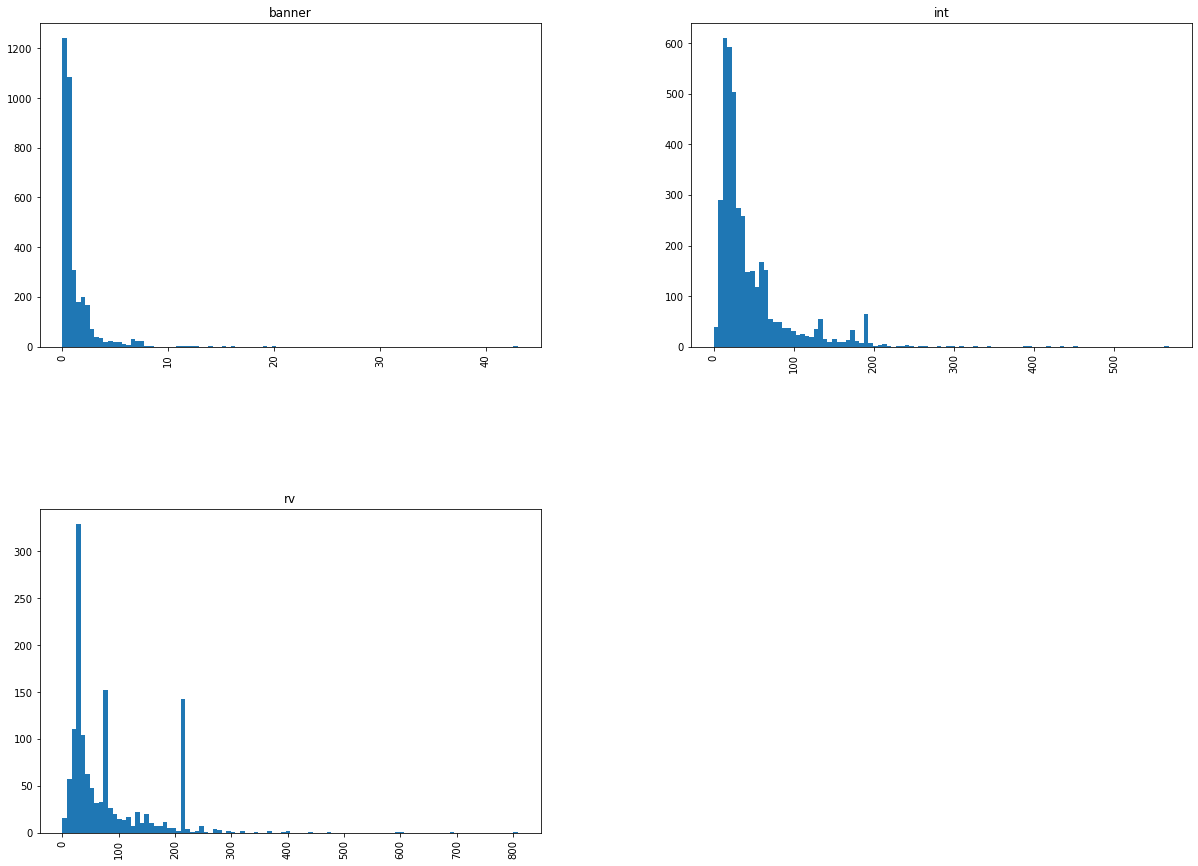

In [358]:
table_hist['eCPM'].hist(by=table_hist['ad_type'], figsize=(20, 15), bins=100)
plt.xlabel('xlabel', fontsize=18)
plt.show()

Дальше найдем из каждой выборки пользователя, который имеет наибольшую среднию eCPM

In [344]:
table_hist.iloc[table_hist[table_hist['ad_type']=='banner']['eCPM'].idxmax()]

ad_type            banner
profile_id    JMALx7q70qG
eCPM            43.021387
Name: 2802, dtype: object

In [346]:
table_hist.iloc[table_hist[table_hist['ad_type']=='int']['eCPM'].idxmax()]

ad_type               int
profile_id    JLs8H01mzVe
eCPM            568.67827
Name: 5383, dtype: object

In [345]:
table_hist.iloc[table_hist[table_hist['ad_type']=='rv']['eCPM'].idxmax()]

ad_type                rv
profile_id    JLtY7hvRXO3
eCPM            808.29482
Name: 8254, dtype: object

Так же найдем из каждой выборки пользователя, который имеет наименьшую среднию eCPM

In [347]:
table_hist.iloc[table_hist[table_hist['ad_type']=='banner']['eCPM'].idxmin()]

ad_type            banner
profile_id    JL3xP8xM4Xf
eCPM              0.01393
Name: 57, dtype: object

In [348]:
table_hist.iloc[table_hist[table_hist['ad_type']=='int']['eCPM'].idxmin()]

ad_type               int
profile_id    JL7PaV98HXg
eCPM                  0.0
Name: 3656, dtype: object

In [349]:
table_hist.iloc[table_hist[table_hist['ad_type']=='rv']['eCPM'].idxmin()]

ad_type                rv
profile_id    JL3xP8xM4Xf
eCPM             0.223222
Name: 7486, dtype: object

# Для каждого формата рекламы построим распределение eCPM-ов по городам, версиям ОС

In [350]:
# сгруппируем для каждого ползователя в зависимости от рекламы и города
table_2 = pd.pivot_table(df, values='eCPM', index=['ad_type','os_version', 'city'])

In [351]:
# преобразуем данные для построения графиков
table_hist_2 = table_2.reset_index()

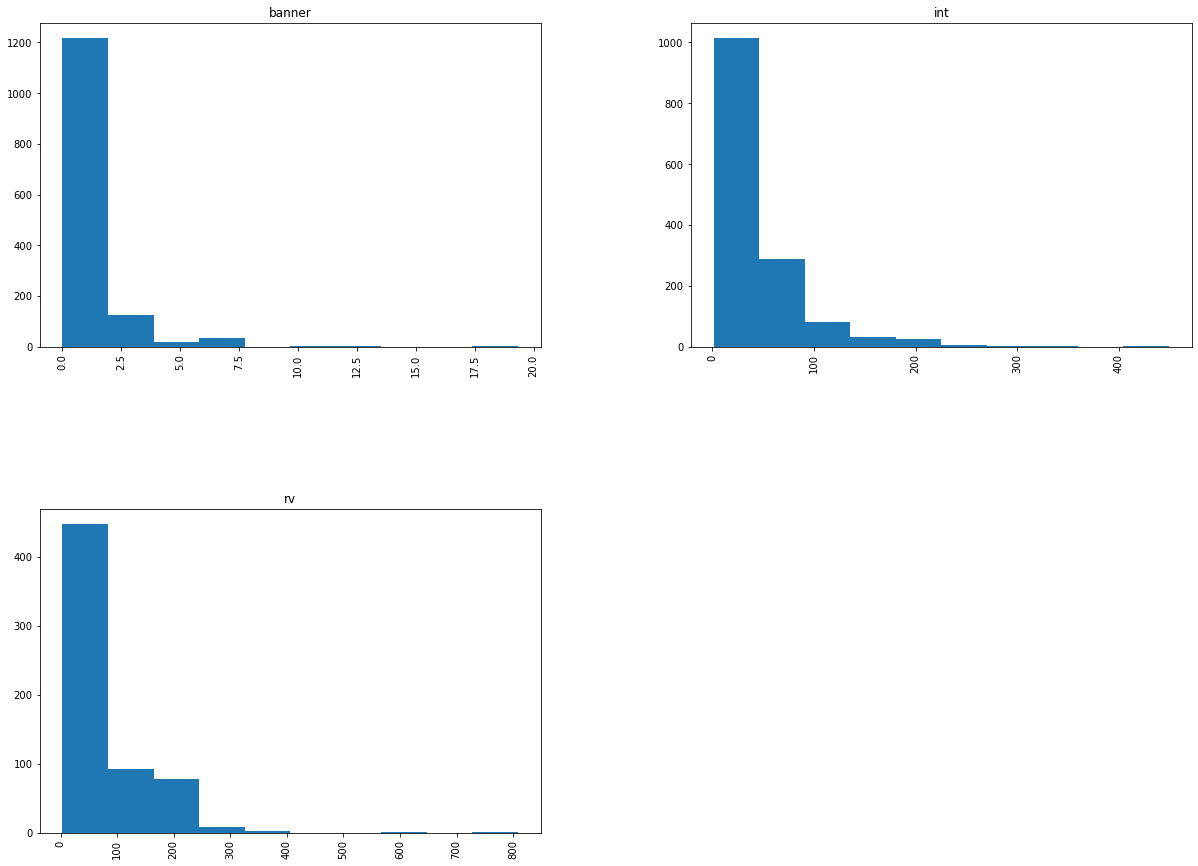

In [357]:
table_hist_2['eCPM'].hist(by=table_hist_2['ad_type'], figsize=(20, 15))
plt.show()

In [376]:
# сгруппируем для каждого ползователя в зависимости от OS
table_2_os = pd.pivot_table(df, values='eCPM', index=['ad_type','os_version'], aggfunc=np.mean)

In [377]:
table_hist_2_os = table_2_os.reset_index()

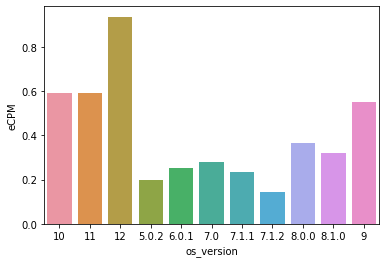

In [452]:
# построим гистограмму для banner
ax = sns.barplot(data=table_hist_2_os[table_hist_2_os['ad_type'] == 'banner'],
                 x='os_version', y='eCPM')

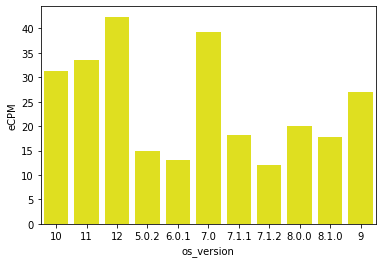

In [451]:
# построим гистограмму для int
ax = sns.barplot(data=table_hist_2_os[table_hist_2_os['ad_type'] == 'int'],
                 x='os_version', y='eCPM', color='yellow')

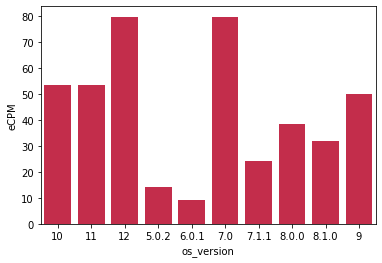

In [450]:
# построим гистограмму для rv
ax = sns.barplot(data=table_hist_2_os[table_hist_2_os['ad_type'] == 'rv'],
                 x='os_version', y='eCPM', color='crimson')

In [413]:
# сгруппируем для каждого пользователя в зависимости от city
table_2_city = pd.pivot_table(df, values='eCPM', index=['ad_type','city'],
                              aggfunc=np.mean).sort_values('eCPM', ascending=False)

In [414]:
table_hist_2_city = table_2_city.reset_index()

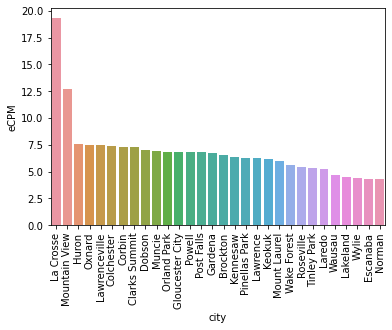

In [449]:
# построим гистограмму для banner
ax = sns.barplot(data=table_hist_2_city[table_hist_2_city['ad_type'] == 'banner'][:30],
                 x='city', y='eCPM')
plt.xticks(rotation=90)
plt.show()

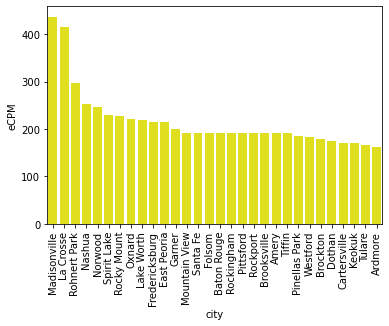

In [448]:
# построим гистограмму для banner
ax = sns.barplot(data=table_hist_2_city[table_hist_2_city['ad_type'] == 'int'][:30],
                 x='city', y='eCPM',color='yellow')
plt.xticks(rotation=90)
plt.show()

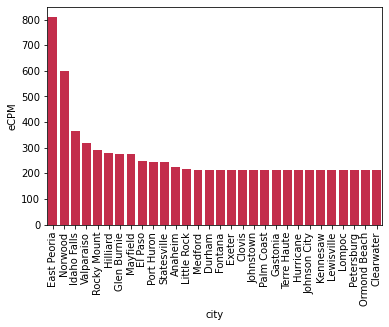

In [447]:
# построим гистограмму для banner
ax = sns.barplot(data=table_hist_2_city[table_hist_2_city['ad_type'] == 'rv'][:30],
                 x='city', y='eCPM', color='crimson')
plt.xticks(rotation=90)
plt.show()

# Для каждого формата рекламы построим распределение доходов по городам, версиям ОС

In [427]:
# вычислим сумму для каждого города и версии ОС
table_3 = pd.pivot_table(df, values='ads_ltv', index=['ad_type','os_version', 'city'], aggfunc=np.sum)

In [428]:
# преобразуем данные для построения графиков
table_hist_3 = table_3.reset_index()

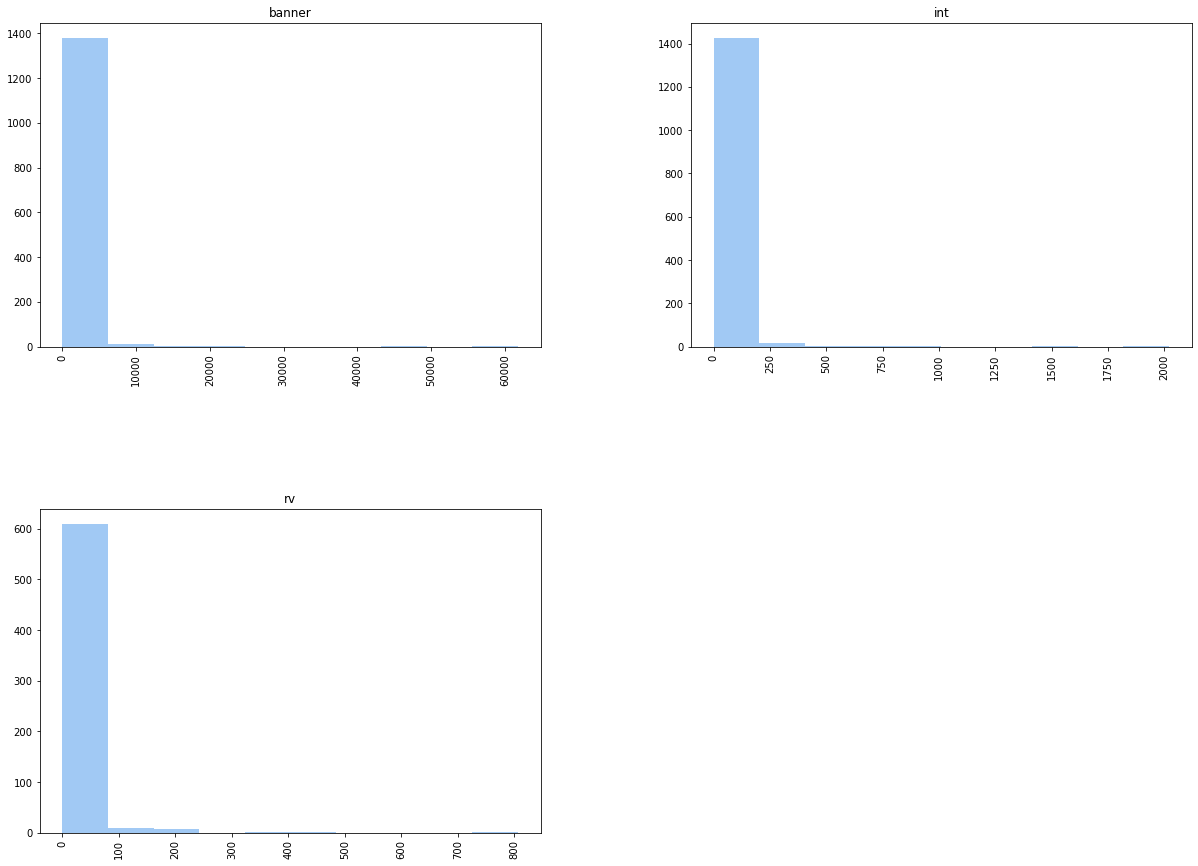

In [429]:
table_hist_3['ads_ltv'].hist(by=table_hist_3['ad_type'], figsize=(20, 15))
plt.show()

In [479]:
# сгруппируем для каждого ползователя в зависимости от OS
table_3_os = pd.pivot_table(df, values='ads_ltv', index=['ad_type','os_version'], aggfunc=np.sum)

In [480]:
table_hist_3_os = table_3_os.reset_index()

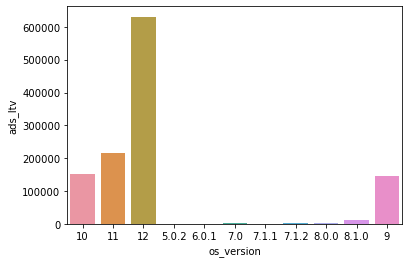

In [481]:
# построим гистограмму для banner
ax = sns.barplot(data=table_hist_3_os[table_hist_3_os['ad_type'] == 'banner'],
                 x='os_version', y='ads_ltv')

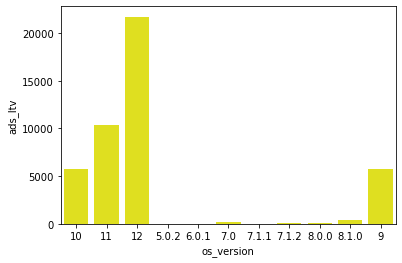

In [445]:
# построим гистограмму для int
ax = sns.barplot(data=table_hist_3_os[table_hist_3_os['ad_type'] == 'int'],
                 x='os_version', y='ads_ltv', color='yellow')

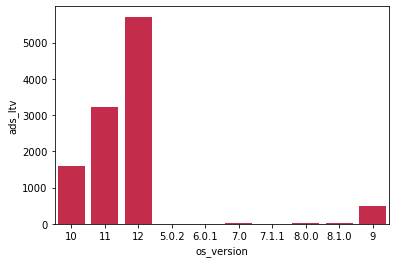

In [444]:
# построим гистограмму для rv
ax = sns.barplot(data=table_hist_3_os[table_hist_3_os['ad_type'] == 'rv'],
                 x='os_version', y='ads_ltv', color='crimson')

In [438]:
# сгруппируем для каждого пользователя в зависимости от city
table_3_city = pd.pivot_table(df, values='ads_ltv', index=['ad_type','city'],
                              aggfunc=np.sum).sort_values('ads_ltv', ascending=False)

In [442]:
table_hist_3_city = table_3_city.reset_index()

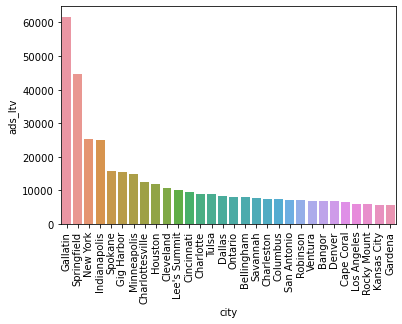

In [443]:
# построим гистограмму для banner
ax = sns.barplot(data=table_hist_3_city[table_hist_3_city['ad_type'] == 'banner'][:30],
                 x='city', y='ads_ltv')
plt.xticks(rotation=90)
plt.show()

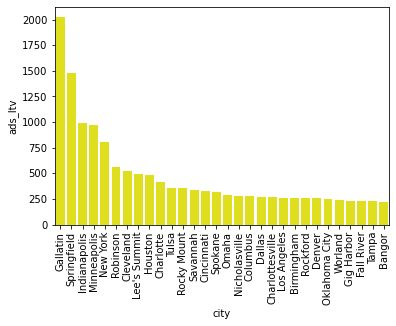

In [453]:
# построим гистограмму для banner
ax = sns.barplot(data=table_hist_3_city[table_hist_3_city['ad_type'] == 'int'][:30],
                 x='city', y='ads_ltv',color='yellow')
plt.xticks(rotation=90)
plt.show()

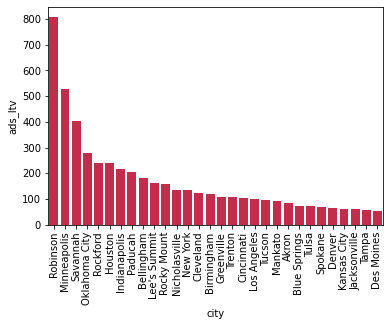

In [454]:
# построим гистограмму для banner
ax = sns.barplot(data=table_hist_3_city[table_hist_3_city['ad_type'] == 'rv'][:30],
                 x='city', y='ads_ltv', color='crimson')
plt.xticks(rotation=90)
plt.show()

# Учтем статистическую значимость.

##### 1. По распределению средних eCPM-ов юзеров

In [272]:
# выделим данные по юзерам отдельно для каждой рекламы
banner_user = table_hist[table_hist['ad_type'] == 'banner']['eCPM']
int_user = table_hist[table_hist['ad_type'] == 'int']['eCPM']
rv_user = table_hist[table_hist['ad_type'] == 'rv']['eCPM']

In [273]:
# получим описательную статистику по каждой рекламе
table_hist.groupby('ad_type').describe()

eCPM                                                        \
          count       mean        std       min        25%        50%   
ad_type                                                                 
banner   3508.0   1.157111   1.867792  0.013930   0.322804   0.583002   
int      3962.0  45.557457  46.877344  0.000000  17.620615  27.623670   
rv       1324.0  80.502004  79.154906  0.223222  28.240000  46.019935   

                                
               75%         max  
ad_type                         
banner    1.297329   43.021387  
int      56.397665  568.678270  
rv       98.067206  808.294820

<AxesSubplot:xlabel='ad_type', ylabel='eCPM'>

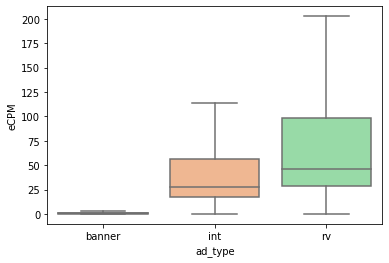

In [455]:
# построим бокс плоты с распределениями и отбросим выбросы
sns.boxplot(x="ad_type", y="eCPM", showfliers = False, data=table_hist)

Так как все 3 распределения не относятся к нормальным, что визуально видно из графика, то для всех будем проводить исследования при помощи непараметрические тесты.

In [456]:
 mannwhitneyu(list_banner_user.dropna(), list_int_user.dropna())

MannwhitneyuResult(statistic=31541.0, pvalue=0.0)

In [457]:
 mannwhitneyu(list_banner_user.dropna(), list_rv_user.dropna())

MannwhitneyuResult(statistic=6207.0, pvalue=0.0)

In [458]:
 mannwhitneyu(list_int_user.dropna(), list_rv_user.dropna())

MannwhitneyuResult(statistic=1681940.0, pvalue=2.6653780463924845e-85)

##### 2. По распределению eCPM-ов по городам, версиям ОС

In [459]:
# выделим данные по каждой рекламе
banner_city = table_hist_2[table_hist_2['ad_type'] == 'banner']['eCPM']
int_city = table_hist_2[table_hist_2['ad_type'] == 'int']['eCPM']
rv_city = table_hist_2[table_hist_2['ad_type'] == 'rv']['eCPM']

In [460]:
# получим описательную статистику по каждой рекламе
table_hist_2.groupby('ad_type').describe()

eCPM                                                        \
          count       mean        std       min        25%        50%   
ad_type                                                                 
banner   1399.0   1.026833   1.435587  0.012581   0.325671   0.552946   
int      1451.0  43.873930  45.560365  1.300738  17.267366  27.979084   
rv        629.0  79.357208  74.906357  3.339551  28.240000  52.711666   

                                 
                75%         max  
ad_type                          
banner     1.083291   19.326435  
int       52.804745  449.354401  
rv       102.642605  808.294820

<AxesSubplot:xlabel='ad_type', ylabel='eCPM'>

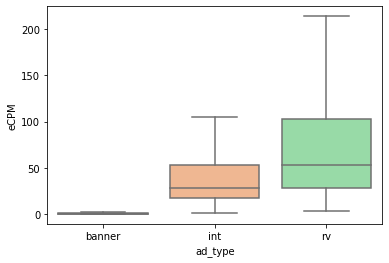

In [461]:
# построим бокс плоты с распределениями
sns.boxplot(x="ad_type", y="eCPM", showfliers = False, data=table_hist_2)

Так как все 3 распределения не относятся к нормальным, что визуально видно из графика, то для всех будем проводить исследования при помощи непараметрические тесты.

In [462]:
 mannwhitneyu(banner_city.dropna(), int_city.dropna())

MannwhitneyuResult(statistic=2644.0, pvalue=0.0)

In [463]:
 mannwhitneyu(banner_city.dropna(), rv_city.dropna())

MannwhitneyuResult(statistic=339.0, pvalue=1.7400640969327864e-284)

In [464]:
 mannwhitneyu(int_city.dropna(), rv_city.dropna())

MannwhitneyuResult(statistic=277802.0, pvalue=1.0322021160730486e-45)

##### 3. По распределению доходов по городам, версиям ОС

In [482]:
# выделим данные по каждой рекламе
banner_city_income = table_hist_3[table_hist_3['ad_type'] == 'banner']['ads_ltv']
int_city_income = table_hist_3[table_hist_3['ad_type'] == 'int']['ads_ltv']
rv_city_income = table_hist_3[table_hist_3['ad_type'] == 'rv']['ads_ltv']

In [483]:
# получим описательную статистику по каждой рекламе
table_hist_3.groupby('ad_type').describe()

ads_ltv                                                          \
          count        mean          std       min       25%        50%   
ad_type                                                                   
banner   1399.0  504.464109  2464.755253  0.000078  4.189232  33.918905   
int      1451.0   18.888333    83.995047  0.002927  0.245276   1.391737   
rv        629.0   12.052288    46.762994  0.012630  0.317791   1.267291   

                                   
                75%           max  
ad_type                            
banner   219.706286  61756.947224  
int        9.364673   2020.654088  
rv         5.557086    806.444566

<AxesSubplot:xlabel='ad_type', ylabel='ads_ltv'>

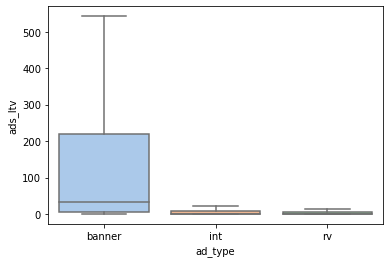

In [484]:
# построим бокс плоты с распределениями
sns.boxplot(x="ad_type", y="ads_ltv", data=table_hist_3, showfliers = False)

Так как все 3 распределения не относятся к нормальным, что визуально видно из графика, то для всех будем проводить исследования при помощи непараметрические тесты.

In [485]:
 mannwhitneyu(banner_city_income.dropna(), int_city_income.dropna())

MannwhitneyuResult(statistic=1562112.0, pvalue=5.231193360905333e-137)

In [486]:
 mannwhitneyu(banner_city_income.dropna(), rv_city_income.dropna())

MannwhitneyuResult(statistic=695141.0, pvalue=3.674238945000109e-97)

In [487]:
 mannwhitneyu(int_city_income.dropna(), rv_city_income.dropna())

MannwhitneyuResult(statistic=464500.0, pvalue=0.5165884559945775)

# Какой процент доходов содержит информацию о городе юзера

Так как все значения доходов (*revenue*) заполнены, то это можно вычислить через подсчета ненулевых значений города (*city*)

In [292]:
print('Процент доходов содержит информацию о городе юзера',round((df['city'].count()/df['revenue'].count())*100, 2), '%' )

Процент доходов содержит информацию о городе юзера 62.36 %


# Зависит ли eCPM от времени дня

За время события возьмем данные event_datetime, после этого извлечем часы и построим корреляцию пирсона

In [305]:
hour_event = pd.DatetimeIndex(df['event_datetime']).hour

In [306]:
ecpm = df['eCPM']

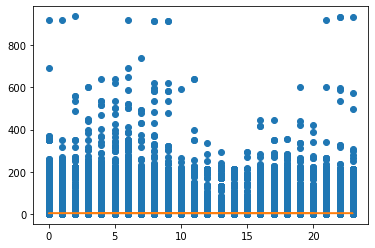

In [309]:
# построим графики
plt.plot(hour_event, ecpm, 'o')
m, b = np.polyfit(hour_event, ecpm, 1)
plt.plot(hour_event, m*hour_event + b)

In [313]:
pearsonr(hour_event,ecpm)

(-0.0014268941502598525, 0.18573339629044958)

**Линейная зависимость отсутствует согласно построенным графикам и полученному коэффициенту Пирсона**

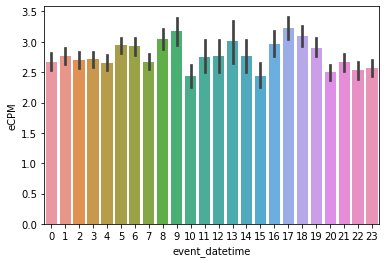

In [472]:
# Построим график распределения по времени в течение дня
ax = sns.barplot(data=df, x=pd.DatetimeIndex(df['event_datetime']).hour, y='eCPM')

*Очень большую помеху дают выбросы. Избавимся от них с помощью квантилей и построим повторно график изменения по времени*

In [322]:
df_tmp = pd.DataFrame(list(zip(hour_event,ecpm)),
               columns =['Hour', 'ecpm'])

In [324]:
Q1 = df_tmp.quantile(0.25)
Q3 = df_tmp.quantile(0.75)
IQR = Q3 - Q1

df_tmp_new = df_tmp[~((df_tmp < (Q1 - 1.5 * IQR)) |(df_tmp > (Q3 + 1.5 * IQR))).any(axis=1)]

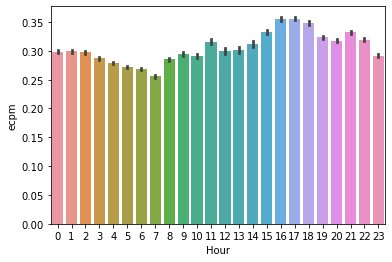

In [471]:
# построим графики
ax = sns.barplot(data=df_tmp_new, x='Hour', y='ecpm')

# Выводы

1. Выборка не сбалансирована. Для ее анализа рекомендуется использовать непараметрические методы.
2. В связи с явным перекосом в сторону количества некоторых значений при дальнейшем анализе можно рассмотреть вариант, как удалить значения с небольшим количеством или объединить их в одно общее значение. Так же можно применить оversampling и undersampling.
3. Полученные выводы из анализа:
* Наиболее популярными марками телефонов являются Samsung, Google,Motorola и LG.Чаще всего пользователи заходят из США. Чаще пользователи пользуются вайфаем.
* Наиболее часто встречается реклама с низким средним eCPM. Так же наиболее доходных по eCPM ползователи: JMALx7q70qG, JLs8H01mzVe, JLtY7hvRXO3 и наименее прибыльных, на которых стоит обратить внимание: JL3xP8xM4Xf, JL7PaV98HXg, JL3xP8xM4Xf
* Чаще всего пользователи пользуются новой операционной системой, но при этом важно отметить что наблюдался так же высокий средний eCPM и при использовании версии 7. Это возможно связано с единичными пользователями, средний показатель которых значительно превышает остальных.
* При непараметрическом анлизе с уровнем 0.05 все тесты кроме одного показали что выборки статистически различаются между собой. Только при одном анализе не удалось установить статистического различия для рекламы int и rv при разделении по распределению доходов по городам, версиям ОС
* При анализе зависимости после отчистки от выбросов был ярко выражен горб после 15 часов с пиками в 16 и 17 часов, после чего наблюдается снижение. Так же во время снижения наблюдается всплеск в 21 час. Это согласуется со временем окончания работы и вечерним отдыхом дома